In [5]:
import json
from bertopic import BERTopic

with open('ontoxGPAHE.json', 'r') as f:
    data = json.load(f)

descriptions = [entry["Description"] for entry in data.values()]

In [18]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(descriptions, show_progress_bar=True)

Batches:   0%|          | 0/25 [00:00<?, ?it/s]

In [19]:
import umap
import pandas as pd
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

In [20]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

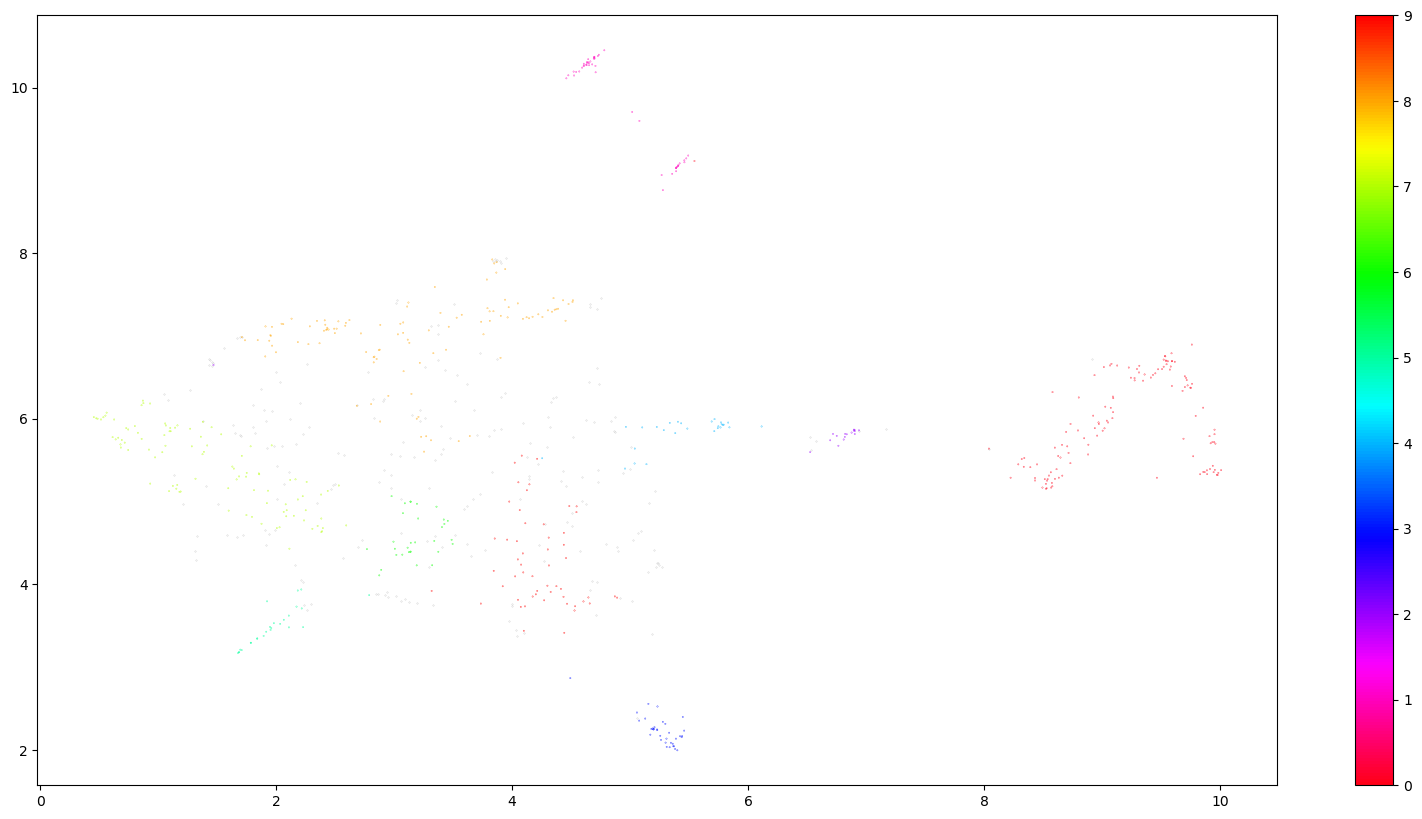

In [21]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [22]:
docs_df = pd.DataFrame(descriptions, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [23]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

In [24]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,228
1,0,126
9,8,108
8,7,98
10,9,54
2,1,48
4,3,36
7,6,31
5,4,27
6,5,26


In [48]:
top_n_words[6]

[('party', 0.02625762774924358),
 ('alternative', 0.019481197677812583),
 ('swedish', 0.019037341702487234),
 ('são', 0.018689463318145104),
 ('paulo', 0.018450531548063476),
 ('chega', 0.01655235533056244),
 ('led', 0.0162574494855264),
 ('integralist', 0.016065808342459482),
 ('2000', 0.015094596852515626),
 ('mon', 0.0150742726549714),
 ('fib', 0.014599232039170913),
 ('1143', 0.014599232039170913),
 ('political', 0.014540347064231601),
 ('blue', 0.013912097454443047),
 ('red', 0.013684635842879097),
 ('far', 0.013446307029756778),
 ('2023', 0.01338378788834389),
 ('junge', 0.013206365710224667),
 ('serbian', 0.01303010537578884),
 ('mspi', 0.01303010537578884)]

In [1]:
import pickle

with open('top_n_words.pkl', 'wb') as fp:
    pickle.dump(top_n_words, fp)
    print('dictionary saved successfully to file')

NameError: name 'top_n_words' is not defined

In [ ]:
with open('top_n_words.pkl', 'rb') as fp:
    top_n_words_dict = pickle.load(fp)
    print(top_n_words_dict)

{-1: [('far', 0.00936268652146801), ('lgbtq', 0.008858938962333697), ('right', 0.008734365695398741), ('black', 0.008218610201809952), ('groups', 0.007829999712941389), ('anti', 0.007781786779686359), ('ukrainian', 0.007537486670260046), ('organization', 0.007482712199943981), ('background', 0.007444312235374685), ('party', 0.007353797644962205), ('logo', 0.007300562367897174), ('blue', 0.007280526048875328), ('flag', 0.00680891272178421), ('founded', 0.006459467726846458), ('circle', 0.006377351750961311), ('neo', 0.006320548731332275), ('national', 0.006306857425667069), ('group', 0.006306160684536091), ('red', 0.0062893360446338205), ('includes', 0.006183608128955069)], 0: [('club', 0.03187157788363491), ('active', 0.030574054452191482), ('sports', 0.027122746715960905), ('clubs', 0.02693738018560956), ('rundo', 0.026313115314590137), ('robert', 0.02618512798819017), ('train', 0.026142933561690947), ('upcoming', 0.025968426503572527), ('oppressive', 0.025968426503572527), ('perceive